# Implementation of Finite Mixture Model

## Import Needed Libraries and Filepaths

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma, norm
import matplotlib.pyplot as plt
from texas_gerrymandering_hb4.config import FINAL_CSV

## Load Dataset Into DataFrame

In [1]:
df = pd.read_csv(FINAL_CSV)


2025-12-01 16:04:56.307 | INFO     | texas_gerrymandering_hb4.config:<module>:11 - PROJ_ROOT path is: /home/algorithmicprogrammer/Documents/texas-gerrymandering-hb4


,district_id,polsby_popper,schwartzberg,convex_hull_ratio,reock,pct_white,pct_black,pct_asian,pct_hispanic,dem_share,rep_share
0,1,0.193575,0.439971,0.722970,0.407570,0.632532,0.184984,0.014875,0.142830,0.252671,0.728964
1,2,0.165232,0.406487,0.625270,0.417351,0.526751,0.125050,0.072934,0.255189,0.399379,0.577517
2,3,0.216761,0.465576,0.805445,0.273916,0.577914,0.112669,0.111327,0.172895,0.403698,0.573637
3,4,0.103462,0.321654,0.574190,0.222752,0.605524,0.099241,0.157600,0.108877,0.405732,0.575123
4,5,0.184465,0.429494,0.823171,0.310183,0.522819,0.159980,0.034848,0.261670,0.481179,0.498040


## Prepare Outcomes

### Define Response Variable `y`
* `y` represents the Democratic vote share per district.

In [ ]:
y = df["dem_share"].values.astype(float)

### Define Sample Size
* `n` represents the sample size or the number of districts (38).

In [ ]:
n = len(y)

### Obtaining Mean and Standard Deviation
* The mean and standard deviation are computed for assistance in setting hyperparameters.

In [ ]:
y.mean(), y.std(ddof=1)

## Setting Up Mixture Model

### Setting Up Reproducible Random Number Generator

In [ ]:
np.random.seed(456)

### Setting Initial Values

In [ ]:
z = np.random.randint(0, 2, size=n)
lambda_curr = 0.5
mu_curr = np.array([y.mean() - 0.05, y.mean() + 0.05])
sigma2_curr = np.array([y.var(), y.var()])

### Setting Priors

In [ ]:
alpha1 = 2.0
alpha2 = 2.0

m0 = y.mean()
s0_sq = (y.std(ddof=1) ** 2) * 4  # relatively diffuse prior

a0 = 2.0
b0 = 1.0

### Gibbs Sampler Parameters

In [ ]:
n_iter_mix = 20000
burn_in_mix = 5000

### Storage for Samples

In [3]:
lambda_samples = np.zeros(n_iter_mix)
mu_samples = np.zeros((n_iter_mix, 2))
sigma2_samples_mix = np.zeros((n_iter_mix, 2))
z_samples = np.zeros((n_iter_mix, n), dtype=int)


In [4]:
# CELL 3 — Gibbs sampler for mixture model

for it in range(n_iter_mix):
    # Sample z
    for i in range(n):
        ll0 = norm.pdf(y[i], loc=mu_curr[0], scale=np.sqrt(sigma2_curr[0]))
        ll1 = norm.pdf(y[i], loc=mu_curr[1], scale=np.sqrt(sigma2_curr[1]))
        p0 = lambda_curr * ll0
        p1 = (1 - lambda_curr) * ll1
        denom = p0 + p1
        if denom == 0:
            p0 = p1 = 0.5
        else:
            p0 /= denom
            p1 /= denom
        z[i] = np.random.choice([0, 1], p=[p0, p1])

    # Sample lambda
    n0 = np.sum(z == 0)
    n1 = n - n0
    lambda_curr = np.random.beta(alpha1 + n0, alpha2 + n1)

    # Sample (mu_k, sigma2_k) for k=0,1
    for k in [0, 1]:
        yk = y[z == k]
        nk = len(yk)
        if nk > 0:
            yk_mean = yk.mean()
            ssq = np.sum((yk - yk_mean) ** 2)

            ak = a0 + nk / 2.0
            bk = b0 + 0.5 * ssq
            sigma2_curr[k] = invgamma.rvs(a=ak, scale=bk)

            s2_post = 1 / (nk / sigma2_curr[k] + 1 / s0_sq)
            m_post = s2_post * (nk * yk_mean / sigma2_curr[k] + m0 / s0_sq)
            mu_curr[k] = np.random.normal(loc=m_post, scale=np.sqrt(s2_post))
        else:
            sigma2_curr[k] = invgamma.rvs(a=a0, scale=b0)
            mu_curr[k] = np.random.normal(loc=m0, scale=np.sqrt(s0_sq))

    lambda_samples[it] = lambda_curr
    mu_samples[it, :] = mu_curr
    sigma2_samples_mix[it, :] = sigma2_curr
    z_samples[it, :] = z

lambda_post = lambda_samples[burn_in_mix:]
mu_post = mu_samples[burn_in_mix:, :]
sigma2_post_mix = sigma2_samples_mix[burn_in_mix:, :]
z_post = z_samples[burn_in_mix:, :]

In [5]:
# CELL 4 — Posterior summaries and classification

lambda_mean = lambda_post.mean()
mu_mean = mu_post.mean(axis=0)
sigma_mean = np.sqrt(sigma2_post_mix.mean(axis=0))

print("Posterior mean lambda:", lambda_mean)
print("Posterior mean mu0, mu1:", mu_mean)
print("Posterior mean sigma0, sigma1:", sigma_mean)

# Posterior probability of component 1
p_comp1 = (z_post == 1).mean(axis=0)
map_comp = (p_comp1 > 0.5).astype(int)

df["mix_comp"] = map_comp
df["p_comp1"] = p_comp1

df[["district_id", "dem_share", "mix_comp", "p_comp1"]].head()


Posterior mean lambda: 0.39144345998584396
Posterior mean mu0, mu1: [0.4678701  0.46401695]
Posterior mean sigma0, sigma1: [0.66964944 0.53065295]


,district_id,dem_share,mix_comp,p_comp1
0,1,0.252671,1,0.616267
1,2,0.399379,1,0.622200
2,3,0.403698,1,0.621600
3,4,0.405732,1,0.618533
4,5,0.481179,1,0.619133


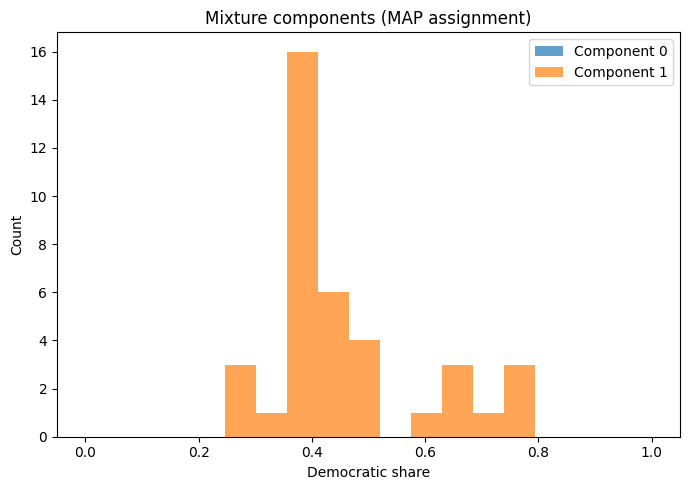

In [6]:
# CELL 5 — Visualize mixture components

plt.hist(y[map_comp == 0], bins=10, alpha=0.7, label="Component 0")
plt.hist(y[map_comp == 1], bins=10, alpha=0.7, label="Component 1")
plt.xlabel("Democratic share")
plt.ylabel("Count")
plt.title("Mixture components (MAP assignment)")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# CELL 6 — Save mixture results

mix_results = df[["district_id", "dem_share", "mix_comp", "p_comp1"]].copy()
mix_results.to_csv("mixture_results.csv", index=False)
mix_results.head()


,district_id,dem_share,mix_comp,p_comp1
0,1,0.252671,1,0.616267
1,2,0.399379,1,0.622200
2,3,0.403698,1,0.621600
3,4,0.405732,1,0.618533
4,5,0.481179,1,0.619133
